# Extending ImageJ: Ops

This notebook illustrates how to create new `Op` plugins, and run them with ImageJ's `OpService`.

The plugins are in Groovy cells, but coded in Java style.

In [1]:
#@ImageJ ij

// Behind a firewall? Configure your proxy settings here.
//System.setProperty("http.proxyHost","myproxy.domain")
//System.setProperty("http.proxyPort","8080")

"ImageJ is ready to go."

ImageJ is ready to go.

## `narf` - a very simple op

Here is a "Hello, world" style op, to illustrate the basics:

In [5]:
import net.imagej.ops.AbstractOp
import net.imagej.ops.Op
import org.scijava.ItemIO
import org.scijava.plugin.Parameter
import org.scijava.plugin.Plugin
import org.scijava.plugin.PluginInfo

// The @Plugin annotation allows this Op to be discovered by the OpService.
// We declare the type of op, the name of the op, and any optional aliases...
@Plugin(type = Op.class, name = "narf")
public class Narf extends AbstractOp {
  
  // INPUTS, declared using @Parameter notation
  @Parameter
  private String input
  
  // OUTPUTS, declared using @Parameter notation
  @Parameter(type = ItemIO.OUTPUT)
  private String output
  
  @Override
  public void run() {
    // The job of the run method is to populate any outputs using the inputs
    output = "Egads! " + input.toUpperCase()
  }
}

// The @Plugin annotation is processed by the javac compiler,
// which is used to generate the metadata in class bytecode.
// Unfortunately, the Groovy compiler doesn't invoke the javac
// compiler, so we need to register the plugin manually!
narfInfo = new PluginInfo(Narf.class, Op.class)
ij.plugin().addPlugin(narfInfo)
narfInfo

name='narf', priority=0​.0, enabled=true, pluginType=Op

Now you can start using your new Op.

In [4]:
// Execute our Op and get the result
result = ij.op().run("narf", "Put some trousers on")

Egads! PUT SOME TROUSERS ON

## `ramp` - an op which produces an image

This example illustrates how to create a new Op that constructs a ramp image.

In [6]:
import net.imagej.ops.AbstractOp
import net.imagej.ops.Op
import org.scijava.ItemIO
import org.scijava.plugin.Parameter
import org.scijava.plugin.Plugin
import org.scijava.plugin.PluginInfo
import net.imglib2.Cursor;
import net.imglib2.img.array.ArrayImg
import net.imglib2.img.array.ArrayImgs
import net.imglib2.img.basictypeaccess.array.DoubleArray
import net.imglib2.type.numeric.RealType
import net.imglib2.type.numeric.real.DoubleType

// The @Plugin annotation allows this Op to be discovered by the OpService.
// We declare the type of op, the name of the op, and any optional aliases...
@Plugin(type = Op.class, name = "ramp")
public class Ramp<T extends RealType<T>> extends AbstractOp {

  // INPUTS, declared using @Parameter annotation
  @Parameter(required = false)
  private int size = 256

  // OUTPUTS, declared using @Parameter notation
  @Parameter(type = ItemIO.OUTPUT)
  private ArrayImg<DoubleType, DoubleArray> rampImg

  @Override
  public void run() {
    rampImg = ArrayImgs.doubles(size, size)

    Cursor<DoubleType> c = rampImg.localizingCursor()
    long[] pos = new long[rampImg.numDimensions()]
    
    // Iterate the image and get the each pixel location
    // Every pixel value is assigned its locations sum,
    // so generate the ramp pattern image.
    while (c.hasNext()) {
      c.fwd()
      c.localize(pos)
      c.get().setReal(sum(pos))
    }
  }
  
  // a sum method to be called in our Op
  private float sum(long[] pos) {
    float sum = 0
    for (long p : pos) {
      sum += p
    }
    return sum
  }
}

// The @Plugin annotation is processed by the javac compiler,
// which is used to generate the metadata in class bytecode.
// Unfortunately, the Groovy compiler doesn't invoke the javac
// compiler, so we need to register the plugin manually!
rampInfo = new PluginInfo(Ramp.class, Op.class)
ij.plugin().addPlugin(rampInfo)
rampInfo

name='ramp', priority=0​.0, enabled=true, pluginType=Op

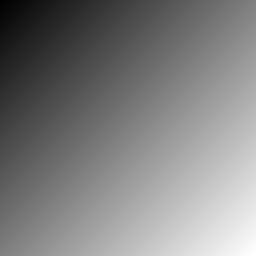

In [13]:
ramp = ij.op().run("ramp")

Note that the resulting image is 256x256, since we did not specify the `size` parameter, and it is annotated with `required = false`. We can optionally pass the size to get a differently sized gradient:

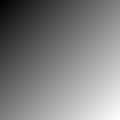

In [7]:
smallRamp = ij.op().run("ramp", 120)

## `blobs` - a more complex op

This next example illustrates how to create a new op that constructs a 'random blobs' image.

In [8]:
import java.util.Random
import net.imagej.ops.AbstractOp
import net.imagej.ops.Op
import net.imglib2.RandomAccess
import net.imglib2.RandomAccessibleInterval
import net.imglib2.img.array.ArrayImgs
import net.imglib2.type.numeric.RealType
import net.imglib2.util.IntervalIndexer
import net.imglib2.util.Intervals
import org.scijava.ItemIO
import org.scijava.log.LogService
import org.scijava.plugin.Parameter
import org.scijava.plugin.Plugin
import org.scijava.plugin.PluginInfo

// The @Plugin annotation allows this Op to be discovered by the OpService.
// We declare the type of op, the name of the op, and any optional aliases...
@Plugin(type = Op.class, name = "blobs")
public class RandomBlobs<T extends RealType<T>> extends AbstractOp {

  // OUTPUTS, declared using @Parameter notation
  @Parameter(type = ItemIO.OUTPUT)
  private RandomAccessibleInterval<T> image
  
  @Parameter
  private LogService log
  
  @Parameter
  private int blobNum
  
  @Parameter
  private int blobSize
  
  @Parameter
  private int xDim
  
  @Parameter
  private int yDim
  
  @Parameter(required = false)
  private long seed = 0xcafebabe
  
  @Override
  public void run() {
    // produce a XxY float64 array-backed image using the input parameters
    image = ArrayImgs.doubles(xDim, yDim)
    long[] pos = new long[image.numDimensions()]
    
    long[] blobCenter = new long[image.numDimensions()]
    long[] dims = new long[image.numDimensions()]
    image.dimensions(dims)
    
    // get the total number elements of the image
    long total = Intervals.numElements(image)
    
    Random r = new Random(seed)
    
    RandomAccess<T> ra = image.randomAccess(image)
    
    // Iterate to generate each blob
    for (int i = 0; i < blobNum; i++) {
      // generate a random positon in [0, total)
      long index = (long) (r.nextDouble() * total)
      // convert the linear index to the 2-D index
      // For example, index = 59662, dims = [256,256],
      // then blobCenter = [14,233]
      IntervalIndexer.indexToPosition(index, dims, blobCenter)
      
      // For generating current blob, it is necessary to scan
      // the whole image to determine the elements which are
      // locate in the radius of the blobCenter.
      for (int j = 0; j < total; j++) {
        IntervalIndexer.indexToPosition(j, dims, pos)
        double dist = distance(pos, blobCenter)
        if (dist > blobSize) {
          continue
        }
        
        // This element is in the radius of the blobCenter, so it is 
        // assigned with value inversely proportional to the distance.
        // Namely, if the distance is 0.0, then the norm is 1.0; if the
        // distance is blobSize, then the norm is 0.0, and so on.
        ra.setPosition(pos)
        double norm = 1.0 - dist / blobSize
        ra.get().setReal(Math.max(ra.get().getRealDouble(), norm))
      }
    }
  }
  /**
   * Computes distance between the given position and a center point.
   */
  private double distance(long[] pos, long[] center) {
    long sumDistSquared = 0
    for (int d = 0; d < center.length; d++) {
      long dist = pos[d] - center[d]
      sumDistSquared += dist * dist
    }
    return Math.sqrt(sumDistSquared)
  }
}

// The @Plugin annotation is processed by the javac compiler,
// which is used to generate the metadata in class bytecode.
// Unfortunately, the Groovy compiler doesn't invoke the javac
// compiler, so we need to register the plugin manually!
blobsInfo = new PluginInfo(RandomBlobs.class, Op.class)
ij.plugin().addPlugin(blobsInfo)
blobsInfo

name='blobs', priority=0​.0, enabled=true, pluginType=Op

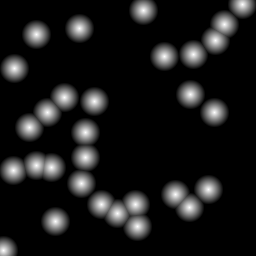

In [9]:
blobs = ij.op().run("blobs", 30, 15, 256, 256)